In [1]:
!pip install biopython
!pip install aaindex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.0/373.0 kB 7.5 MB/s eta 0:00:00


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParamData
from aaindex import aaindex1
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix
import sklearn.metrics as skl

In [3]:
complete_train = pd.read_csv("complete_train.tsv", sep='\t')

In [4]:
complete_train.head()

,id,organism_name,kingdom,seq_len,SP,validation_n,sp_type,sequence
0,Q99MA2,Rattus norvegicus,Metazoa,674,22,3,1,MAQAYWQCYPWLVLLCACAWSYPGPESLGREDVRDCSTNPPRLPVT...
1,P17948,Homo sapiens,Metazoa,1338,26,1,1,MVSYWDTGVLLCALLSCLLLTGSSSGSKLKDPELSLKGTQHIMQAG...
2,P41271,Homo sapiens,Metazoa,181,16,1,1,MMLRVLVGAVLPAMLLAAPPPINKLALFPDKSAWCEAKNITQIVGH...
3,Q8I948,Acanthoscurria gomesiana,Metazoa,156,23,4,1,MAFRMKLVVCIVLLSTLAVMSSADVYKGGGGGRYGGGRYGGGGGYG...
4,Q92154,Coturnix japonica,Metazoa,620,17,4,1,MELLVLTVLLMGTGCISAPWAAWMPPKMAALSGTCVQLPCRFDYPE...


In [5]:
order = list("ARNDCQEGHILKMFPSTWYV")
aa_index = {}
for i, aa in enumerate(order):
  aa_index[aa]= i

print(aa_index)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


In [6]:
def aa_composition(sequence, length: int, aa_index):
  sequence = sequence[:length]
  freq = np.zeros((1, 20))
  for aa in sequence:
    if aa in aa_index.keys():
      freq[0, aa_index[aa]] += 1
  freq = np.round(freq/len(sequence), 3)
  return freq

aa_comp = np.vstack(complete_train['sequence'].apply(aa_composition, args=(22, aa_index)))
aa_comp

array([[0.182, 0.   , 0.   , ..., 0.136, 0.136, 0.045],
       [0.045, 0.   , 0.   , ..., 0.045, 0.045, 0.091],
       [0.182, 0.045, 0.   , ..., 0.   , 0.   , 0.136],
       ...,
       [0.091, 0.   , 0.045, ..., 0.   , 0.   , 0.045],
       [0.   , 0.136, 0.045, ..., 0.   , 0.   , 0.136],
       [0.045, 0.091, 0.   , ..., 0.   , 0.   , 0.136]])

In [7]:
def hydrophobicity(sequence, window: int, length: int):
    sequence = sequence[:length]
    seq = ProteinAnalysis(sequence)
    kd_pos = seq.protein_scale(ProtParamData.kd,window)
    d = int(window/2)
    sequence_with_padding = "X"*d + sequence + "X"*d
    seq_padding = ProteinAnalysis(sequence_with_padding)
    kd_pos_with_padding = seq_padding.protein_scale(ProtParamData.kd, window)
    return kd_pos_with_padding

hydro = np.vstack(complete_train['sequence'].apply(hydrophobicity, args=(5,40)))

Output streaming troncato alle ultime 5000 righe.


In [8]:
feature_codes = {
    "net_charge": ("KLEP840101", 2),
    "hydrophilicity": ("HOPT810101", 5),
    "helix_propensity": ("CHAM830101",7),
    "flexibility": ("BHAR880101", 7),
    "isoelectric_point": ("ZIMJ680104", 2),
    "bulkiness": ("ZIMJ680102", 7)
}

def features(sequence, length: int, feature_code, window: int):
  sequence = sequence[:length]
  seq = ProteinAnalysis(sequence)
  vals = aaindex1[feature_code].values
  val = seq.protein_scale(vals,window)
  mean = np.mean(val)
  std = np.std(val)
  max = np.max(val)
  return np.round([mean, std, max], 3)

feats = {}
for feature in feature_codes.keys():
  feats[feature] = np.vstack(complete_train['sequence'].apply(features, args=(30, feature_codes[feature][0], feature_codes[feature][1])))

np.savez('separate_features.npz', aa_comp = aa_comp, hydrophobicity = hydro, **feats)

In [9]:
extracted_features = np.load("separate_features.npz")
# Create a dictionary from the loaded features, handling multi-dimensional arrays
data = {}
for key in extracted_features.files:
    arr = extracted_features[key]
    if arr.ndim > 1:
        # If the array is multi-dimensional, create multiple columns
        for i in range(arr.shape[1]):
            data[f'{key}_{i+1}'] = arr[:, i]
    else:
        # If the array is 1-dimensional, use it directly
        data[key] = arr

X = pd.DataFrame(data)

In [10]:
X["id"] = complete_train["id"]
X["validation_n"] = complete_train["validation_n"]
y = complete_train["sp_type"]
X.head()


,aa_comp_1,aa_comp_2,aa_comp_3,aa_comp_4,aa_comp_5,aa_comp_6,aa_comp_7,aa_comp_8,aa_comp_9,aa_comp_10,...,flexibility_2,flexibility_3,isoelectric_point_1,isoelectric_point_2,isoelectric_point_3,bulkiness_1,bulkiness_2,bulkiness_3,id,validation_n
0,0.182,0.000,0.0,0.000,0.136,0.091,0.000,0.000,0.0,0.000,...,0.046,0.499,5.844,0.744,9.163,15.949,2.369,20.414,Q99MA2,3
1,0.045,0.000,0.0,0.045,0.091,0.000,0.000,0.091,0.0,0.000,...,0.043,0.512,5.919,0.862,8.487,14.830,2.777,18.876,P17948,1
2,0.182,0.045,0.0,0.000,0.000,0.000,0.000,0.045,0.0,0.045,...,0.029,0.469,6.202,0.890,9.167,16.859,0.937,18.960,P41271,1
3,0.091,0.045,0.0,0.000,0.045,0.000,0.000,0.000,0.0,0.045,...,0.027,0.488,6.171,1.044,9.000,16.351,2.594,20.339,Q8I948,4
4,0.136,0.000,0.0,0.000,0.045,0.000,0.045,0.091,0.0,0.045,...,0.026,0.458,5.952,0.680,8.593,16.017,2.508,20.644,Q92154,4


In [11]:
def make_groups():
    l = [_ for _ in range(5)]
    group = {}
    for i in l:
        print(f'{(i%5)+1} {((i+1)%5)+1} {((i+2)%5)+1} {((i+3)%5)+1} {((i+4)%5)+1}')
        train = (((i%5)+1 ,((i+1)%5)+1 ,((i+2)%5)+1))
        test = ((i+3)%5)+1
        cross_val = ((i+4)%5)+1
        name_test = f'test_{i+1}'
        group[name_test] = (train, test, cross_val)
    return group

groups = make_groups()

1 2 3 4 5
2 3 4 5 1
3 4 5 1 2
4 5 1 2 3
5 1 2 3 4



=== TEST_1 ===
Train: (1, 2, 3), Val: 4, Test: 5
Baseline SVM (all features) — best validation accuracy: 0.978 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0   hydrophilicity_1    0.088525
1  hydrophobicity_12    0.065966
2  hydrophobicity_10    0.057519
3  hydrophobicity_11    0.053042
4  hydrophobicity_13    0.051843
5        bulkiness_3    0.051351
6      flexibility_1    0.043066
7         aa_comp_11    0.042454
8   hydrophobicity_9    0.041239
9   hydrophobicity_8    0.035510


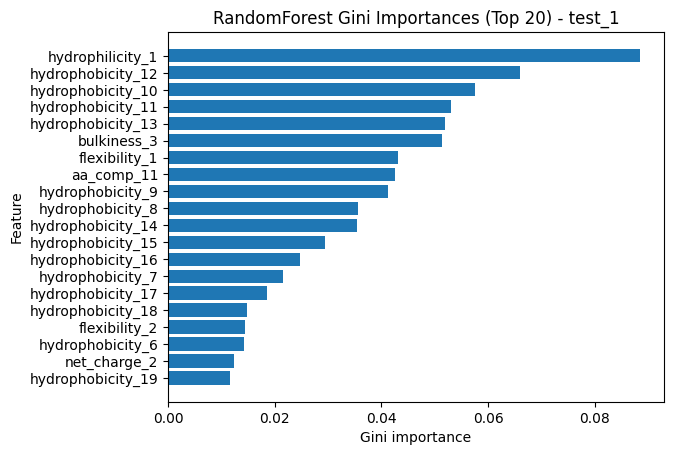

Best k on validation (using baseline best params): k=22, val_acc=0.975


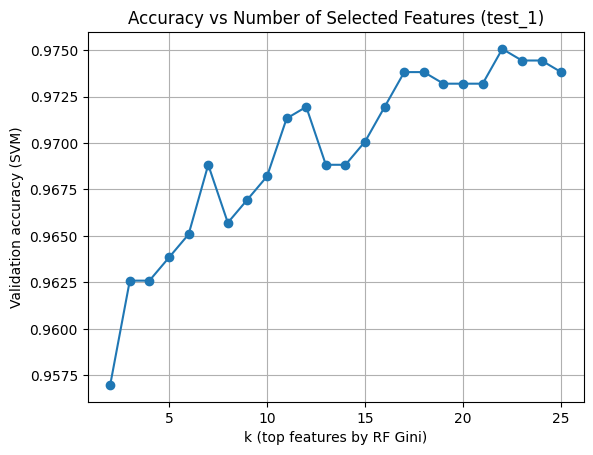


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.976
   → Found with parameters: C = 1.0, gamma = 0.1

Final test accuracy (using selected features): 0.970
Final test accuracy (using all features - baseline model): 0.976

 The baseline model (all features) performs slightly better on the test set.

=== SVM con FEATURE SELEZIONATE ===
MCC = 0.849 | ACC = 0.970 | PPV = 0.847 | SEN = 0.886
Confusion Matrix:
 [[1402   28]
 [  20  155]]

=== SVM con TUTTE LE FEATURE (BASELINE) ===
MCC = 0.881 | ACC = 0.976 | PPV = 0.854 | SEN = 0.937
Confusion Matrix:
 [[1402   28]
 [  11  164]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.849370  0.970093  0.846995  0.885714
1       All features  0.881254  0.975701  0.854167  0.937143

=== TEST_2 ===
Train: (2, 3, 4), Val: 5, Test: 1


In [ ]:
def svm_pipeline(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42))
    ])

def accuracy_on_subset(C, gamma, subset_features):
    # subset by feature names
    # Convert data keys to a NumPy array for use with np.where
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in subset_features]
    Xtr = X_train.iloc[:, idx]
    Xva = X_val.iloc[:, idx]
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)     # train on TRAIN only
    return pipe.score(Xva, y_val)  # accuracy on VALIDATION


def metrics(obs_test, y_pred_test):
  MCC = skl.matthews_corrcoef(obs_test, y_pred_test)            # Matthews Correlation Coefficient
  ACC = skl.accuracy_score(obs_test, y_pred_test)               # Accuracy
  PPV = skl.precision_score(obs_test, y_pred_test)              # Precision
  SEN = skl.recall_score(obs_test, y_pred_test)                 # Recall
  CONF =skl.confusion_matrix(obs_test , y_pred_test)            # Confusion Matrix
  return MCC, ACC, PPV, SEN, CONF

results = []

# Define search grids for SVM hyperparameters C and gamma.
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]


all_metrics_svm = []
# Each iteration corresponds to one cross-validation fold.
# For each fold, we define TRAIN, VALIDATION, and TEST sets based on validation_n values.
for name, (train_idx, val_idx, test_idx) in groups.items():
    print(f"\n=== {name.upper()} ===")
    print(f"Train: {train_idx}, Val: {val_idx}, Test: {test_idx}")

    # Filter the main dataset (X and y) according to the fold indices.
    # Drop non-numerical or identifier columns such as 'id' and 'validation_n'.
    X_train = X[X["validation_n"].isin(train_idx)].drop(columns=["id", "validation_n"])
    X_val   = X[X["validation_n"].isin([val_idx])].drop(columns=["id", "validation_n"])
    X_test  = X[X["validation_n"].isin([test_idx])].drop(columns=["id", "validation_n"])

    y_train = y[complete_train["validation_n"].isin(train_idx)]
    y_val   = y[complete_train["validation_n"].isin([val_idx])]
    y_test  = y[complete_train["validation_n"].isin([test_idx])]

    # Convert the DataFrames into NumPy arrays and save them in a single .npz file.
    # This stores all matrices for the current fold (train, validation, test) in one place.

    X_train_np = X_train.to_numpy()
    X_val_np = X_val.to_numpy()
    X_test_np = X_test.to_numpy()

    y_train_np = y_train.to_numpy()
    y_val_np = y_val.to_numpy()
    y_test_np = y_test.to_numpy()

    np.savez(
        f"cv_set_{name}.npz",
        X_train=X_train_np,
        X_val=X_val_np,
        X_test=X_test_np,
        y_train=y_train_np,
        y_val=y_val_np,
        y_test=y_test_np
    )

    # Perform a manual grid search over C and gamma values.
    # Evaluate each model on the VALIDATION set and store the best parameters.
    best_score_base = -np.inf
    best_params_base = None

    for C in C_grid:
        for gamma in gamma_grid:
            pipe = svm_pipeline(C, gamma)
            pipe.fit(X_train, y_train)                 # fit on TRAIN
            val_acc = pipe.score(X_val, y_val)         # evaluate on VALIDATION
            if val_acc > best_score_base:
                best_score_base = val_acc
                best_params_base = {"C": C, "gamma": gamma}

    print("Baseline SVM (all features) — best validation accuracy: "
          f"{best_score_base:.3f} with params {best_params_base}")


    # Train a Random Forest classifier on the training data.
    # Use the Gini importance to rank features by their predictive power.
    rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
    )
    rf.fit(X_train, y_train)

    gini_imp = pd.Series(rf.feature_importances_, index=list(data.keys())).sort_values(ascending=False)
    gini_df = gini_imp.reset_index()
    gini_df.columns = ["feature", "importance"]
    print("Top 10 features by Gini importance:")
    print(gini_df.head(10))

    # Visualize the 20 most important features as determined by the Random Forest.
    # Save the figure for documentation of this fold.
    plt.figure()
    plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
    plt.xlabel("Gini importance")
    plt.ylabel("Feature")
    plt.title(f"RandomForest Gini Importances (Top 20) - {name}")
    plt.savefig(f"gini_importances_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()



    # Test multiple subsets of top-k features ranked by Gini importance.
    # For each subset size, evaluate the validation accuracy of the baseline SVM.
    ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
    curve = []

    for k in ks:
        subset = gini_df["feature"].head(k).tolist()
        acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
        curve.append(acc_k)

    best_k_idx = int(np.argmax(curve))
    best_k = ks[best_k_idx]
    print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

    # Visualize how validation accuracy changes with different numbers of features.
    # The best k will correspond to the peak of the curve.
    plt.figure()
    plt.plot(ks, curve, marker="o")
    plt.xlabel("k (top features by RF Gini)")
    plt.ylabel("Validation accuracy (SVM)")
    plt.title(f"Accuracy vs Number of Selected Features ({name})")
    plt.grid(True)
    plt.savefig(f"accuracy_vs_features_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()


    # Keep only the best_k features and re-run the grid search to find new optimal parameters.
    best_subset = gini_df["feature"].head(best_k).tolist()
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in best_subset]

    Xtr_sel = X_train.iloc[:, idx]
    Xva_sel = X_val.iloc[:, idx]
    Xte_sel = X_test.iloc[:, idx]

    best_score_sel = -np.inf
    best_params_sel = None

    for C in C_grid:
        for gamma in gamma_grid:
            pipe = svm_pipeline(C, gamma)
            pipe.fit(Xtr_sel, y_train)      # train on TRAIN
            val_acc = pipe.score(Xva_sel, y_val)  # validate on VAL
            if val_acc > best_score_sel:
                best_score_sel = val_acc
                best_params_sel = {"C": C, "gamma": gamma}


    # Train a final SVM on the selected features using the best parameters.
    # Evaluate on the TEST set and compare to the baseline (all features).
    final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
    final_pipe.fit(Xtr_sel, y_train)
    test_acc = final_pipe.score(Xte_sel, y_test)

    # For comparison: test accuracy with all features using baseline best params
    baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
    baseline_pipe.fit(X_train, y_train)
    test_acc_all = baseline_pipe.score(X_test, y_test)

    print("\n--- RESULTS SUMMARY ---")
    print(f"Best validation accuracy (after feature selection): {best_score_sel:.3f}")
    print(f"   → Found with parameters: C = {best_params_sel['C']}, gamma = {best_params_sel['gamma']}")

    print(f"\nFinal test accuracy (using selected features): {test_acc:.3f}")
    print(f"Final test accuracy (using all features - baseline model): {test_acc_all:.3f}")

    if test_acc > test_acc_all:
      print("\n The model with feature selection performs slightly better on the test set.")
    elif test_acc == test_acc_all:
      print("\n The model with selected features performs the same as the baseline.")
    else:
      print("\n The baseline model (all features) performs slightly better on the test set.")


    #METRICS
    y_pred_sel = final_pipe.predict(Xte_sel)
    y_pred_all = baseline_pipe.predict(X_test)

    obs_test = y_test

    MCC_sel, ACC_sel, PPV_sel, SEN_sel, CONF_sel = metrics(obs_test, y_pred_sel)
    MCC_all, ACC_all, PPV_all, SEN_all, CONF_all = metrics(obs_test, y_pred_all)



    print("\n=== SVM con FEATURE SELEZIONATE ===")
    print(f"MCC = {MCC_sel:.3f} | ACC = {ACC_sel:.3f} | PPV = {PPV_sel:.3f} | SEN = {SEN_sel:.3f}")
    print("Confusion Matrix:\n", CONF_sel)

    print("\n=== SVM con TUTTE LE FEATURE (BASELINE) ===")
    print(f"MCC = {MCC_all:.3f} | ACC = {ACC_all:.3f} | PPV = {PPV_all:.3f} | SEN = {SEN_all:.3f}")
    print("Confusion Matrix:\n", CONF_all)

    results = pd.DataFrame({
    'Model': ['Selected features', 'All features'],
    'MCC': [MCC_sel, MCC_all],
    'ACC': [ACC_sel, ACC_all],
    'PPV': [PPV_sel, PPV_all],
    'SEN': [SEN_sel, SEN_all]
    })

    print(results)









# For each cross-validation fold:
# - We trained an SVM baseline on all features.
# - We ranked features by importance using a Random Forest.
# - We determined the optimal number of top features (k) using validation accuracy curves.
# - We retrained an SVM using only the top-k features.
# - We compared test accuracy with and without feature selection.
# - We saved all datasets (.npz), plots, and results for reproducibility.